In [1]:
from IPython.display import Image

# CNTK 204: Sequence to Sequence Networks with Text Data


## Introduction and Background

This hands-on tutorial will take you through both the basics of sequence-to-sequence networks, and how to implement them in the Microsoft Cognitive Toolkit. In particular, we will implement a sequence-to-sequence model with attention to perform grapheme to phoneme translation. We will start with some basic theory and then explain the data in more detail, and how you can download it.

Andrej Karpathy has a [nice visualization](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) of five common paradigms of neural network architectures:

In [2]:
# Figure 1
Image(url="http://cntk.ai/jup/paradigms.jpg", width=750)

In this tutorial, we are going to be talking about the fourth paradigm: many-to-many where the length of the output does not necessarily equal the length of the input, also known as sequence-to-sequence networks. The input is a sequence with a dynamic length, and the output is also a sequence with some dynamic length. It is the logical extension of the many-to-one paradigm in that previously we were predicting some category (which could easily be one of `V` words where `V` is an entire vocabulary) and now we want to predict a whole sequence of those categories.

The applications of sequence-to-sequence networks are nearly limitless. It is a natural fit for machine translation (e.g. English input sequences, French output sequences); automatic text summarization (e.g. full document input sequence, summary output sequence); word to pronunciation models (e.g. character [grapheme] input sequence, pronunciation [phoneme] output sequence); and even parse tree generation (e.g. regular text input, flat parse tree output).

## Basic theory

A sequence-to-sequence model consists of two main pieces: (1) an encoder; and (2) a decoder. Both the encoder and the decoder are recurrent neural network (RNN) layers that can be implemented using a vanilla RNN, an LSTM, or GRU Blocks (here we will use LSTM). In the basic sequence-to-sequence model, the encoder processes the input sequence into a fixed representation that is fed into the decoder as a context. The decoder then uses some mechanism (discussed below) to decode the processed information into an output sequence. The decoder is a language model that is augmented with some "strong context" by the encoder, and so each symbol that it generates is fed back into the decoder for additional context (like a traditional LM). For an English to German translation task, the most basic setup might look something like this:

In [3]:
# Figure 2
Image(url="http://cntk.ai/jup/s2s.png", width=700)

The basic sequence-to-sequence network passes the information from the encoder to the decoder by initializing the decoder RNN with the final hidden state of the encoder as its initial hidden state. The input is then a "sequence start" tag (`<s>` in the diagram above) which primes the decoder to start generating an output sequence. Then, whatever word (or note or image, etc.) it generates at that step is fed in as the input for the next step. The decoder keeps generating outputs until it hits the special "end sequence" tag (`</s>` above).

A more complex and powerful version of the basic sequence-to-sequence network uses an attention model. While the above setup works well, it can start to break down when the input sequences get long. At each step, the hidden state `h` is getting updated with the most recent information, and therefore `h` might be getting "diluted" in information as it processes each token. Further, even with a relatively short sequence, the last token will always get the last say and therefore the thought vector will be somewhat biased/weighted towards that last word. To deal with this problem, we use an "attention" mechanism that allows the decoder to look not only at all of the hidden states from the input, but it also learns which hidden states, for each step in decoding, to put the most weight on. In this tutorial we will implement a sequence-to-sequence network that can be run either with or without attention enabled.

In [4]:
# Figure 3
Image(url="https://cntk.ai/jup/cntk204_s2s2.png", width=700)

The `Attention` layer above takes the current value of the hidden state in the Decoder, all of the hidden states in the Encoder, and calculates an augmented version of the hidden state to use. More specifically, the contribution from the Encoder's hidden states will represent a weighted sum of all of its hidden states where the highest weight corresponds both to the biggest contribution to the augmented hidden state and to the hidden state that will be most important for the Decoder to consider when generating the next word.

## Problem: Grapheme-to-Phoneme Conversion

The [grapheme](https://en.wikipedia.org/wiki/Grapheme) to [phoneme](https://en.wikipedia.org/wiki/Phoneme) problem is a translation task that takes the letters of a word as the input sequence (the graphemes are the smallest units of a writing system) and outputs the corresponding phonemes; that is, the units of sound that make up a language. In other words, the system aims to generate an unambigious representation of how to pronounce a given input word.

### Example

The graphemes or the letters are translated into corresponding phonemes: 

> **Grapheme** : **|** T **|** A **|** N **|** G **|** E **|** R **|**  
**Phonemes** : **|** ~T **|** ~AE **|** ~NG **|** ~ER **|**




## Task and Model Structure

As discussed above, the task we are interested in solving is creating a model that takes some sequence as an input, and generates an output sequence based on the contents of the input. The model's job is to learn the mapping from the input sequence to the output sequence that it will generate. The job of the encoder is to come up with a good representation of the input that the decoder can use to generate a good output. For both the encoder and the decoder, the LSTM does a good job at this.

Note that the LSTM is simply one of a whole set of different types of Blocks that can be used to implement an RNN. This is the code that is run for each step in the recurrence. In the Layers library, there are three built-in recurrent Blocks: the (vanilla) `RNN`, the `GRU`, and the `LSTM`. Each processes its input slightly differently and each has its own benefits and drawbacks for different types of tasks and networks. To get these blocks to run for each of the elements recurrently in a network, we create a `Recurrence` over them. This "unrolls" the network to the number of steps that are in the given input for the RNN layer.

## Importing CNTK and other useful libraries

CNTK is a Python module that contains several submodules like `io`, `learner`, `graph`, etc. We make extensive use of numpy as well.

In [5]:
from __future__ import print_function
import numpy as np
import os

import cntk as C

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [6]:
# Define a test environment
def isTest():
    return ('TEST_DEVICE' in os.environ) 

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

## Downloading the data

In this tutorial we will use a lightly pre-processed version of the CMUDict (version 0.7b) dataset from http://www.speech.cs.cmu.edu/cgi-bin/cmudict. The CMUDict data refers to the Carnegie Mellon University Pronouncing Dictionary and is an open-source machine-readable pronunciation dictionary for North American English. The data is in the CNTKTextFormatReader format. Here is an example sequence pair from the data, where the input sequence (S0) is in the left column, and the output sequence (S1) is on the right:

```
0	|S0 3:1  |# <s>	  |S1 3:1 |# <s>
0	|S0 4:1  |# A	    |S1 32:1 |# ~AH
0	|S0 5:1  |# B	    |S1 36:1 |# ~B
0	|S0 4:1  |# A	    |S1 31:1 |# ~AE
0	|S0 7:1  |# D	    |S1 38:1 |# ~D
0	|S0 12:1 |# I	    |S1 47:1 |# ~IY
0	|S0 1:1  |# </s>	 |S1 1:1 |# </s>
```

The code below will download the required files (training, testing, the single sequence above for visual validation, and a small vocab file) and put them in a local folder (the training file is ~34 MB, testing is ~4MB, and the validation file and vocab file are both less than 1KB).

In [7]:
import requests

def download(url, filename):
    """ utility function to download a file """
    response = requests.get(url, stream=True)
    with open(filename, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

MODEL_DIR = "."
DATA_DIR = os.path.join('..', 'Examples', 'SequenceToSequence', 'CMUDict', 'Data')
# If above directory does not exist, just use current.
if not os.path.exists(DATA_DIR):
    DATA_DIR = '.'

dataPath = {
  'validation': 'tiny.ctf',
  'training': 'cmudict-0.7b.train-dev-20-21.ctf',
  'testing': 'cmudict-0.7b.test.ctf',
  'vocab_file': 'cmudict-0.7b.mapping',
}

for k in sorted(dataPath.keys()):
    path = os.path.join(DATA_DIR, dataPath[k])
    if os.path.exists(path):
        print("Reusing locally cached:", path)
    else:
        print("Starting download:", dataPath[k])
        url = "https://github.com/Microsoft/CNTK/blob/v2.0.rc3/Examples/SequenceToSequence/CMUDict/Data/%s?raw=true"%dataPath[k]
        download(url, path)
        print("Download completed")
    dataPath[k] = path

Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\cmudict-0.7b.test.ctf
Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\cmudict-0.7b.train-dev-20-21.ctf
Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\tiny.ctf
Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\cmudict-0.7b.mapping


## Reader

To efficiently collect our data, randomize it for training, and pass it to the network, we use the CNTKTextFormat reader. We will create a small function that will be called when training (or testing) that defines the names of the streams in our data, and how they are referred to in the raw training data.

In [8]:
# Helper function to load the model vocabulary file
def get_vocab(path):
    # get the vocab for printing output sequences in plaintext
    vocab = [w.strip() for w in open(path).readlines()]
    i2w = { i:w for i,w in enumerate(vocab) }
    w2i = { w:i for i,w in enumerate(vocab) }
    
    return (vocab, i2w, w2i)

# Read vocabulary data and generate their corresponding indices
vocab, i2w, w2i = get_vocab(dataPath['vocab_file'])

def create_reader(path, is_training):
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        features = StreamDef(field='S0', shape=input_vocab_dim, is_sparse=True),
        labels   = StreamDef(field='S1', shape=label_vocab_dim, is_sparse=True)
    )), randomize = is_training, max_sweeps = INFINITELY_REPEAT if is_training else 1)

In [9]:
input_vocab_dim  = 69
label_vocab_dim  = 69

# Print vocab and the correspoding mapping to the phonemes
print("Vocabulary size is", len(vocab))
print("First 15 letters are:")
print(vocab[:15])
print()
print("Print dictionary with the vocabulary mapping:")
print(i2w)

Vocabulary size is 69
First 15 letters are:
["'", '</s>', '<s/>', '<s>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']

Print dictionary with the vocabulary mapping:
{0: "'", 1: '</s>', 2: '<s/>', 3: '<s>', 4: 'A', 5: 'B', 6: 'C', 7: 'D', 8: 'E', 9: 'F', 10: 'G', 11: 'H', 12: 'I', 13: 'J', 14: 'K', 15: 'L', 16: 'M', 17: 'N', 18: 'O', 19: 'P', 20: 'Q', 21: 'R', 22: 'S', 23: 'T', 24: 'U', 25: 'V', 26: 'W', 27: 'X', 28: 'Y', 29: 'Z', 30: '~AA', 31: '~AE', 32: '~AH', 33: '~AO', 34: '~AW', 35: '~AY', 36: '~B', 37: '~CH', 38: '~D', 39: '~DH', 40: '~EH', 41: '~ER', 42: '~EY', 43: '~F', 44: '~G', 45: '~HH', 46: '~IH', 47: '~IY', 48: '~JH', 49: '~K', 50: '~L', 51: '~M', 52: '~N', 53: '~NG', 54: '~OW', 55: '~OY', 56: '~P', 57: '~R', 58: '~S', 59: '~SH', 60: '~T', 61: '~TH', 62: '~UH', 63: '~UW', 64: '~V', 65: '~W', 66: '~Y', 67: '~Z', 68: '~ZH'}


We will use the above to create a reader for our training data. Let's create it now:

In [10]:
def create_reader(path, is_training):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        features = C.io.StreamDef(field='S0', shape=input_vocab_dim, is_sparse=True),
        labels   = C.io.StreamDef(field='S1', shape=label_vocab_dim, is_sparse=True)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

# Train data reader
train_reader = create_reader(dataPath['training'], True)

# Validation data reader
valid_reader = create_reader(dataPath['validation'], True)

### Now let's set our model hyperparameters...

We have a number of settings that control the complexity of our network, the shapes of our inputs, and other options such as whether we will use an embedding (and what size to use), and whether or not we will employ attention. We set them now as they will be made use of when we build the network graph in the following sections.

In [11]:
hidden_dim = 512
num_layers = 2
attention_dim = 128
attention_span = 20
attention_axis = -3
use_attention = True
use_embedding = True
embedding_dim = 200
vocab = ([w.strip() for w in open(dataPath['vocab_file']).readlines()]) # all lines of vocab_file in a list
length_increase = 1.5

We will set two more parameters now: the symbols used to denote the start of a sequence (sometimes called 'BOS') and the end of a sequence (sometimes called 'EOS'). In this case, our sequence-start symbol is the tag $<s>$ and our sequence-end symbol is the end-tag $</s>$.

Sequence start and end tags are important in sequence-to-sequence networks for two reasons. The sequence start tag is a "primer" for the decoder; in other words, because we are generating an output sequence and RNNs require some input, the sequence start token "primes" the decoder to cause it to emit its first generated token. The sequence end token is important because the decoder will learn to output this token when the sequence is finished. Otherwise the network wouldn't know how long of a sequence to generate. For the code below, we setup the sequence start symbol as a `Constant` so that it can later be passed to the Decoder LSTM as its `initial_state`. Further, we get the sequence end symbol's index so that the Decoder can use it to know when to stop generating tokens.

In [12]:
sentence_start =C.Constant(np.array([w=='<s>' for w in vocab], dtype=np.float32))
sentence_end_index = vocab.index('</s>')

## Step 1: setup the input to the network

### Dynamic axes in CNTK (Key concept)

One of the important concepts in understanding CNTK is the idea of two types of axes:
- **static axes**, which are the traditional axes of a variable's shape, and
- **dynamic axes**, which have dimensions that are unknown until the variable is bound to real data at computation time.

The dynamic axes are particularly important in the world of recurrent neural networks. Instead of having to decide a maximum sequence length ahead of time, padding your sequences to that size, and wasting computation, CNTK's dynamic axes allow for variable sequence lengths that are automatically packed in minibatches to be as efficient as possible.

When setting up sequences, there are *two dynamic axes* that are important to consider. The first is the *batch axis*, which is the axis along which multiple sequences are batched. The second is the dynamic axis particular to that sequence. The latter is specific to a particular input because of variable sequence lengths in your data. For example, in sequence to sequence networks, we have two sequences: the **input sequence**, and the **output (or 'label') sequence**. One of the things that makes this type of network so powerful is that the length of the input sequence and the output sequence do not have to correspond to each other. Therefore, both the input sequence and the output sequence require their own unique dynamic axis.

We first create the `inputAxis` for the input sequence and the `labelAxis` for the output sequence. We then define the inputs to the model by creating sequences over these two unique dynamic axes. Note that `InputSequence` and `LabelSequence` are *type declarations*. This means that the `InputSequence` is a type that consists of a sequence over the `inputAxis` axis.

In [13]:
# Source and target inputs to the model
inputAxis = C.Axis('inputAxis')
labelAxis = C.Axis('labelAxis')

inputs = C.sequence.input_variable(input_vocab_dim, sequence_axis=inputAxis)
labels = C.sequence.input_variable(label_vocab_dim, sequence_axis=labelAxis)

## Step 2: define the network

As discussed before, the sequence-to-sequence network is, at its most basic, an RNN (LSTM) encoder followed by an RNN (LSTM) decoder, and a dense output layer. We will implement both the Encoder and the Decoder using the CNTK Layers library. Both of these will be created as CNTK Functions. Our `create_model()` Python function creates both the `encode` and `decode` CNTK Functions. The `decode` function directly makes use of the `encode` function and the return value of `create_model()` is the CNTK Function `decode` itself.

We start by passing the input through an embedding (learned as part of the training process). So that this function can be used in the `Sequential` block of the Encoder and the Decoder whether we want an embedding or not, we will use the `identity` function if the `use_embedding` parameter is `False`. We then declare the Encoder layers as follows:

First, we pass the input through our `embed` function and then we stabilize it. This adds an additional scalar parameter to the learning that can help our network converge more quickly during training. Then, for each of the number of LSTM layers that we want in our encoder, except the final one, we set up an LSTM recurrence. The final recurrence will be a `Fold` if we are not using attention because we only pass the final hidden state to the decoder. If we are using attention, however, then we use another normal LSTM `Recurrence` that the Decoder will put its attention over later on.

Below we see a diagram of how the layered version of the sequence-to-sequence network with attention works. As the code shows below, the output of each layer of the Encoder and Decoder is used as the input to the layer just above it. The Attention model focuses on the top layer of the Encoder and informs the first layer of the Decoder.

In [14]:
# Figure 4
Image(url="https://cntk.ai/jup/cntk204_s2s3.png", width=900)

For the decoder, we first define several sub-layers: the `Stabilizer` for the decoder input, the `Recurrence` blocks for each of the decoder's layers, the `Stabilizer` for the output of the stack of LSTMs, and the final `Dense` output layer. If we are using attention, then we also create an `AttentionModel` function `attention_model` which returns an augmented version of the decoder's hidden state with emphasis placed on the encoder hidden states that should be most used for the given step while generating the next output token.

We then build the CNTK Function `decode`. The decorator `@Function` turns a regular Python function into a proper CNTK Function with the given arguments and return value. The Decoder works differently during training than it does during test time. During training, the history (i.e. input) to the Decoder `Recurrence` consists of the ground-truth labels. This means that while generating $y^{(t=2)}$, for example, the input will be $y^{(t=1)}$. During evaluation, or "test time", however, the input to the Decoder will be the actual output of the model. For a greedy decoder -- which we are implementing here -- that input is therefore the `hardmax` of the final `Dense` layer.

The Decoder Function `decode` takes two arguments: (1) the `input` sequence; and (2) the Decoder `history`. First, it runs the `input` sequence through the Encoder function `encode` that we setup earlier. We then get the `history` and map it to its embedding if necessary. Then the embedded representation is stabilized before running it through the Decoder's `Recurrence`. For each layer of `Recurrence`, we run the embedded `history` (now represented as `r`) through the `Recurrence`'s LSTM. If we are not using attention, we run it through the `Recurrence` with its initial state set to the value of the final hidden state of the encoder (note that since we run the Encoder backwards when not using attention that the "final" hidden state is actually the first hidden state in chronological time). If we are using attention, however, then we calculate the auxiliary input `h_att` using our `attention_model` function and we splice that onto the input `x`. This augmented `x` is then used as input for the Decoder's `Recurrence`.

Finally, we stabilize the output of the Decoder, put it through the final `Dense` layer `proj_out`, and label the output using the `Label` layer which allows for simple access to that layer later on.

In [15]:
# create the s2s model
def create_model(): # :: (history*, input*) -> logP(w)*
    
    # Embedding: (input*) --> embedded_input*
    embed = C.layers.Embedding(embedding_dim, name='embed') if use_embedding else identity
    
    # Encoder: (input*) --> (h0, c0)
    # Create multiple layers of LSTMs by passing the output of the i-th layer
    # to the (i+1)th layer as its input
    # Note: We go_backwards for the plain model, but forward for the attention model.
    with C.layers.default_options(enable_self_stabilization=True, go_backwards=not use_attention):
        LastRecurrence = C.layers.Fold if not use_attention else C.layers.Recurrence
        encode = C.layers.Sequential([
            embed,
            C.layers.Stabilizer(),
            C.layers.For(range(num_layers-1), lambda:
                C.layers.Recurrence(C.layers.LSTM(hidden_dim))),
            LastRecurrence(C.layers.LSTM(hidden_dim), return_full_state=True),
            (C.layers.Label('encoded_h'), C.layers.Label('encoded_c')),
        ])

    # Decoder: (history*, input*) --> unnormalized_word_logp*
    # where history is one of these, delayed by 1 step and <s> prepended:
    #  - training: labels
    #  - testing:  its own output hardmax(z) (greedy decoder)
    with C.layers.default_options(enable_self_stabilization=True):
        # sub-layers
        stab_in = C.layers.Stabilizer()
        rec_blocks = [C.layers.LSTM(hidden_dim) for i in range(num_layers)]
        stab_out = C.layers.Stabilizer()
        proj_out = C.layers.Dense(label_vocab_dim, name='out_proj')
        # attention model
        if use_attention: # maps a decoder hidden state and all the encoder states into an augmented state
            attention_model = C.layers.AttentionModel(attention_dim, 
                                                      attention_span, 
                                                      attention_axis, 
                                                      name='attention_model') # :: (h_enc*, h_dec) -> (h_dec augmented)
        # layer function
        @C.Function
        def decode(history, input):
            encoded_input = encode(input)
            r = history
            r = embed(r)
            r = stab_in(r)
            for i in range(num_layers):
                rec_block = rec_blocks[i]   # LSTM(hidden_dim)  # :: (dh, dc, x) -> (h, c)
                if use_attention:
                    if i == 0:
                        @C.Function
                        def lstm_with_attention(dh, dc, x):
                            h_att = attention_model(encoded_input.outputs[0], dh)
                            x = C.splice(x, h_att)
                            return rec_block(dh, dc, x)
                        r = C.layers.Recurrence(lstm_with_attention)(r)
                    else:
                        r = C.layers.Recurrence(rec_block)(r)
                else:
                    # unlike Recurrence(), the RecurrenceFrom() layer takes the initial hidden state as a data input
                    r = C.layers.RecurrenceFrom(rec_block)(*(encoded_input.outputs + (r,))) # :: h0, c0, r -> h                    
            r = stab_out(r)
            r = proj_out(r)
            r = C.layers.Label('out_proj_out')(r)
            return r

    return decode

The network that we defined above can be thought of as an "abstract" model that must first be wrapped to be used. In this case, we will use it first to create a "training" version of the model (where the history for the Decoder will be the ground-truth labels), and then we will use it to create a greedy "decoding" version of the model where the history for the Decoder will be the `hardmax` output of the network. Let's set up these model wrappers next.

## Training

Before starting training, we will define the training wrapper, the greedy decoding wrapper, and the criterion function used for training the model. Let's start with the training wrapper.

In [16]:
def create_model_train(s2smodel):
    # model used in training (history is known from labels)
    # note: the labels must NOT contain the initial <s>
    @C.Function
    def model_train(input, label): # (input*, labels*) --> (word_logp*)

        # The input to the decoder always starts with the special label sequence start token.
        # Then, use the previous value of the label sequence (for training) or the output (for execution).
        past_labels = C.layers.Delay(initial_state=sentence_start)(label)
        return s2smodel(past_labels, input)
    return model_train

Above, we create the CNTK Function `model_train` again using the `@Function` decorator. This function takes the input sequence `input` and the output sequence `labels` as arguments. The `past_labels` are setup as the `history` for the model we created earlier by using the `Delay` layer. This will return the previous time-step value for the input `labels` with an `initial_state` of `sentence_start`. Therefore, if we give the labels `['a', 'b', 'c']`, then `past_labels` will contain `['<s>', 'a', 'b', 'c']` and then return our abstract base model called with the history `past_labels` and the input `input`.

Let's go ahead and create the greedy decoding model wrapper now as well:

In [17]:
def create_model_greedy(s2smodel):
    # model used in (greedy) decoding (history is decoder's own output)
    @C.Function
    def model_greedy(input): # (input*) --> (word_sequence*)

        # Decoding is an unfold() operation starting from sentence_start.
        # We must transform s2smodel (history*, input* -> word_logp*) into a generator (history* -> output*)
        # which holds 'input' in its closure.
        unfold = C.layers.UnfoldFrom(lambda history: s2smodel(history, input) >> C.hardmax,
                            # stop once sentence_end_index was max-scoring output
                            until_predicate=lambda w: w[...,sentence_end_index],
                            length_increase=length_increase)
        
        return unfold(initial_state=sentence_start, dynamic_axes_like=input)
    return model_greedy

Above we create a new CNTK Function `model_greedy` which this time only takes a single argument. This is of course because when using the model at test time we don't have any labels -- it is the model's job to create them for us! In this case, we use the `UnfoldFrom` layer which runs the base model with the current `history` and funnels it into the `hardmax`. The `hardmax`'s output then becomes part of the `history` and we keep unfolding the `Recurrence` until the `sentence_end_index` has been reached. The maximum length of the output sequence (the maximum unfolding of the Decoder) is determined by a multiplier passed to `length_increase`. In this case we set `length_increase` to `1.5` above so the maximum length of each output sequence is 1.5x its input.

The last thing we will do before setting up the training loop is define the function that will create the criterion function for our model.

In [18]:
def create_criterion_function(model):
    @C.Function
    def criterion(input, label):
        # criterion function must drop the <s> from the labels
        postprocessed_labels = C.sequence.slice(label, 1, 0) # <s> A B C </s> --> A B C </s>
        z = model(input, postprocessed_labels)
        ce = C.cross_entropy_with_softmax(z, postprocessed_labels)
        errs = C.classification_error(z, postprocessed_labels)
        return (ce, errs)

    return criterion

Above, we create the criterion function which drops the sequence-start symbol from our labels for us, runs the model with the given `input` and `labels`, and uses the output to compare to our ground truth. We use the loss function `cross_entropy_with_softmax` and get the `classification_error` which gives us the percent-error per-word of our generation accuracy. The CNTK Function `criterion` returns these values as a tuple and the Python function `create_criterion_function(model)` returns that CNTK Function.

Now let's move on to creating the training loop...

In [19]:
def train(train_reader, valid_reader, vocab, i2w, s2smodel, max_epochs, epoch_size):

    # create the training wrapper for the s2smodel, as well as the criterion function
    
    model_train = create_model_train(s2smodel)
    criterion = create_criterion_function(model_train)(inputs, labels)

    # also wire in a greedy decoder so that we can properly log progress on a validation example
    # This is not used for the actual training process.
    model_greedy = create_model_greedy(s2smodel).replace_placeholder(inputs)

    # Instantiate the trainer object to drive the model training
    minibatch_size = 72
    lr = 0.001 if use_attention else 0.005
    learner = C.fsadagrad(model_train.parameters,
                          lr = C.learning_rate_schedule([lr]*2+[lr/2]*3+[lr/4], C.UnitType.sample, epoch_size),
                          momentum = C.momentum_as_time_constant_schedule(1100),
                          gradient_clipping_threshold_per_sample=2.3,
                          gradient_clipping_with_truncation=True)
    trainer = C.Trainer(None, criterion, learner)

    # Get minibatches of sequences to train with and perform model training
    total_samples = 0
    mbs = 0
    eval_freq = 100

    # print out some useful training information
    C.logging.log_number_of_parameters(model_train) ; print()
    progress_printer = C.logging.ProgressPrinter(freq=30, tag='Training')    

    # a hack to allow us to print sparse vectors
    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)(inputs)

    for epoch in range(max_epochs):
        while total_samples < (epoch+1) * epoch_size:
            # get next minibatch of training data
            mb_train = train_reader.next_minibatch(minibatch_size)
            
            # do the training
            trainer.train_minibatch({criterion.arguments[0]: mb_train[train_reader.streams.features], 
                                     criterion.arguments[1]: mb_train[train_reader.streams.labels]})

            progress_printer.update_with_trainer(trainer, with_metric=True) # log progress

            # every N MBs evaluate on a test sequence to visually show how we're doing
            if mbs % eval_freq == 0:
                mb_valid = valid_reader.next_minibatch(1)

                # run an eval on the decoder output model (i.e. don't use the groundtruth)
                e = model_greedy(mb_valid[valid_reader.streams.features])
                print(format_sequences(sparse_to_dense(mb_valid[valid_reader.streams.features]), i2w))
                print("->")
                print(format_sequences(e, i2w))

                # visualizing attention window
                if use_attention:
                    debug_attention(model_greedy, mb_valid[valid_reader.streams.features])

            total_samples += mb_train[train_reader.streams.labels].num_samples
            mbs += 1

        # log a summary of the stats for the epoch
        progress_printer.epoch_summary(with_metric=True)

    # done: save the final model
    model_path = "model_%d.cmf" % epoch
    print("Saving final model to '%s'" % model_path)
    s2smodel.save(model_path)
    print("%d epochs complete." % max_epochs)

In the above function, we created one version of the model for training (plus its associated criterion function) and one version of the model for evaluation. Normally this latter version would not be required but here we have done it so that we can periodically sample from the non-training model to visually understand how our model is converging by seeing the kinds of sequences that it generates as the training progresses.

We then setup some standard variables required for the training loop. We set the `minibatch_size` (which refers to the total number of elements -- NOT sequences -- in a minibatch), the initial learning rate `lr`, we initialize a `learner` using the `adam_sgd` algorithm and a `learning_rate_schedule` that slowly reduces our learning rate. We make use of gradient clipping to help control exploding gradients, and we finally create our `Trainer` object `trainer`.

We make use of CNTK's `ProgressPrinter` class which takes care of calculating average metrics per minibatch/epoch and we set it to update every 30 minibatches. And finally, before starting the training loop, we initialize a function called `sparse_to_dense` which we use to properly print out the input sequence data that we use for validation because it is sparse. That function is defined just below:

In [20]:
# dummy for printing the input sequence below. Currently needed because input is sparse.
def create_sparse_to_dense(input_vocab_dim):
    I = C.Constant(np.eye(input_vocab_dim))
    @C.Function
    def no_op(input):
        return C.times(input, I)
    return no_op

Inside the training loop, we proceed much like many other CNTK networks. We request the next bunch of minibatch data, we perform our training, and we print our progress to the screen using the `progress_printer`. Where we diverge from the norm, however, is where we run an evaluation using our `model_greedy` version of the network and run a single sequence, "ABADI" through to see what the network is currently predicting.

Another difference in the training loop is the optional attention window visualization. Calling the function `debug_attention` shows the weight that the Decoder put on each of the Encoder's hidden states for each of the output tokens that it generated. This function, along with the `format_sequences` function required to print the input/output sequences to the screen, are given below.

In [21]:
# Given a vocab and tensor, print the output
def format_sequences(sequences, i2w):
    return [" ".join([i2w[np.argmax(w)] for w in s]) for s in sequences]

# to help debug the attention window
def debug_attention(model, input):
    q = C.combine([model, model.attention_model.attention_weights])
    #words, p = q(input) # Python 3
    words_p = q(input)
    words = words_p[0]
    p     = words_p[1]
    seq_len = words[0].shape[attention_axis-1]
    span = 7 #attention_span  #7 # test sentence is 7 tokens long
    p_sq = np.squeeze(p[0][:seq_len,:span,0,:]) # (batch, len, attention_span, 1, vector_dim)
    opts = np.get_printoptions()
    np.set_printoptions(precision=5)
    print(p_sq)
    np.set_printoptions(**opts)

Let's try training our network for a small part of an epoch. In particular, we'll run through 25,000 tokens (about 3% of one epoch):

In [22]:
model = create_model()

train(train_reader, valid_reader, vocab, i2w, model, max_epochs=1, epoch_size=25000)

Training 7561400 parameters in 29 parameter tensors.

['<s> A B A D I </s>']
->
['</s>']
[ 0.1434   0.14277  0.14289  0.14291  0.14294  0.14257  0.14252]
 Minibatch[   1-  30]: loss = 4.147692 * 1601, metric = 87.51% * 1601;
 Minibatch[  31-  60]: loss = 3.665605 * 1601, metric = 86.26% * 1601;
 Minibatch[  61-  90]: loss = 3.329608 * 1548, metric = 89.34% * 1548;
['<s> A B A D I </s>']
->
['~N ~N </s>']
[[ 0.14386  0.14317  0.1432   0.14308  0.14289  0.14219  0.14161]
 [ 0.14386  0.14317  0.1432   0.14308  0.14289  0.14219  0.14161]
 [ 0.14386  0.14317  0.1432   0.14308  0.14289  0.14219  0.14161]]
 Minibatch[  91- 120]: loss = 3.240603 * 1567, metric = 86.85% * 1567;
 Minibatch[ 121- 150]: loss = 3.217582 * 1580, metric = 83.54% * 1580;
 Minibatch[ 151- 180]: loss = 3.212167 * 1544, metric = 83.94% * 1544;
['<s> A B A D I </s>']
->
['~R ~R ~AH ~AH ~AH </s>']
[[ 0.1439   0.14321  0.14323  0.14308  0.14287  0.14216  0.14156]
 [ 0.1439   0.14321  0.14322  0.14308  0.14287  0.14216  0.14

As we can see above, while the loss has come down quite a ways, the output sequence is still quite a ways off from what we expect. Uncomment the code below to run for a full epoch (notice that we switch the `epoch_size` parameter to the actual size of the training data) and by the end of the first epoch you will already see a very good grapheme-to-phoneme translation model running!

In [23]:
# Uncomment the line below to train the model for a full epoch
#train(train_reader, valid_reader, vocab, i2w, model, max_epochs=1, epoch_size=908241)

## Testing the network

Now that we've trained a sequence-to-sequence network for graphme-to-phoneme translation, there are two important things we should do with it. First, we should test its accuracy on a held-out test set. Then, we should try it out in an interactive environment so that we can put in our own input sequences and see what the model predicts. Let's start by determining the test string error rate.

At the end of training, we saved the model using the line `s2smodel.save(model_path)`. Therefore, to test it, we will need to first `load` that model and then run some test data through it. Let's `load` the model, then create a reader configured to access our testing data. Note that we pass `False` to the `create_reader` function this time to denote that we are in testing mode so we should only pass over the data a single time.

In [24]:
# load the model for epoch 0
model_path = "model_0.cmf"
model = C.Function.load(model_path)

# create a reader pointing at our testing data
test_reader = create_reader(dataPath['testing'], False)

Now we need to define our testing function. We pass the `reader`, the learned `s2smodel`, and the vocabulary map `i2w` so that we can directly compare the model's predictions to the test set labels. We loop over the test set, evaluate the model on minibatches of size 512 for efficiency, and keep track of the error rate. Note that below we test *per-sequence*. This means that every single token in a generated sequence must match the tokens in the label for that sequence to be considered as correct.

In [25]:
# This decodes the test set and counts the string error rate.
def evaluate_decoding(reader, s2smodel, i2w):
    
    model_decoding = create_model_greedy(s2smodel).replace_placeholder(inputs) # wrap the greedy decoder around the model

    progress_printer = C.logging.ProgressPrinter(tag='Evaluation')

    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)(inputs)

    minibatch_size = 512
    num_total = 0
    num_wrong = 0
    while True:
        mb = reader.next_minibatch(minibatch_size)
        if not mb: # finish when end of test set reached
            break
        e = model_decoding(mb[reader.streams.features])
        outputs = format_sequences(e, i2w)
        labels  = format_sequences(sparse_to_dense(mb[reader.streams.labels]), i2w)
        # prepend sentence start for comparison
        outputs = ["<s> " + output for output in outputs]

        num_total += len(outputs)
        num_wrong += sum([label != output for output, label in zip(outputs, labels)])
        
    rate = num_wrong / num_total
    print("string error rate of {:.1f}% in {} samples".format(100 * rate, num_total))
    return rate

Now we will evaluate the decoding using the above function. If you use the version of the model we trained above with just a small 50000 sample of the training data, you will get an error rate of 100% because we cannot possibly get every single token correct with such a small amount of training. However, if you uncommented the training line above that trains the network for a full epoch, you should have ended up with a much-improved model that showed approximately the following training statistics:

```
Finished Epoch[1 of 300]: [Training] loss = 0.878420 * 799303, metric = 26.23% * 799303 1755.985s (455.2 samples/s);
```

Now let's evaluate the model's test set performance below.

In [26]:
# print the string error rate
evaluate_decoding(test_reader, model, i2w)

string error rate of 100.0% in 12855 samples


1.0

If you did not run the training for the full first epoch, the output above will be a `1.0` meaning 100% string error rate. If, however, you uncommented the line to perform training for a full epoch, you should get an output of `0.569`. A string error rate of `56.9` is actually not bad for a single pass over the data. Let's now modify the above `evaluate_decoding` function to output the per-phoneme error rate. This means that we are calculating the error at a higher precision and also makes things easier in some sense because with the string error rate we could have every phoneme correct but one in each example and still end up with a 100% error rate. Here is the modified version of that function:

In [27]:
# This decodes the test set and counts the string error rate.
def evaluate_decoding(reader, s2smodel, i2w):
    
    model_decoding = create_model_greedy(s2smodel).replace_placeholder(inputs) # wrap the greedy decoder around the model

    progress_printer = C.logging.ProgressPrinter(tag='Evaluation')

    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)(inputs)

    minibatch_size = 512
    num_total = 0
    num_wrong = 0
    while True:
        mb = reader.next_minibatch(minibatch_size)
        if not mb: # finish when end of test set reached
            break
        e = model_decoding(mb[reader.streams.features])
        outputs = format_sequences(e, i2w)
        labels  = format_sequences(sparse_to_dense(mb[reader.streams.labels]), i2w)
        # prepend sentence start for comparison
        outputs = ["<s> " + output for output in outputs]
        
        for s in range(len(labels)):
            for w in range(len(labels[s])):
                num_total += 1
                if w < len(outputs[s]): # in case the prediction is longer than the label
                    if outputs[s][w] != labels[s][w]:
                        num_wrong += 1
                
    rate = num_wrong / num_total
    print("{:.1f}".format(100 * rate))
    return rate

In [28]:
# print the phoneme error rate
test_reader = create_reader(dataPath['testing'], False)
evaluate_decoding(test_reader, model, i2w)

45.0


0.45012815036309267

If you're using the model that was trained for one full epoch, then you should get a phoneme error rate of around 10%. Not bad! This means that for each of the 383,294 phonemes in the test set, our model predicted nearly 90% of them correctly (if you used the quickly-trained version of the model then you will get an error rate of around 45%). Now, let's work with an interactive session where we can input our own input sequences and see how the model predicts their pronunciation (i.e. phonemes). Additionally, we will visualize the Decoder's attention for these samples to see which graphemes in the input it deemed to be important for each phoneme that it produces. Note that in the examples below the results will only be good if you use a model that has been trained for at least one epoch.

## Interactive session

Here we will write an interactive function to make it easy to interact with the trained model and try out your own input sequences that do not appear in the test set. Please note that the results will be very poor if you just use the model that was trained for a very short amount of time. The model we used just above that was trained for one epoch does a good job, and if you have the time and patience to train the model for a full 30 epochs, it will perform very nicely.

We will first import some graphics libraries that make the attention visualization possible and then we will define the `translate` function that takes a numpy-based representation of the input and runs our model.

In [29]:
# imports required for showing the attention weight heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def translate(tokens, model_decoding, vocab, i2w, show_attention=False):

    vdict = {v:i for i,v in enumerate(vocab)}
    try:
        w = [vdict["<s>"]] + [vdict[c] for c in tokens] + [vdict["</s>"]]
    except:
        print('Input contains an unexpected token.')
        return []

    # convert to one_hot
    query = C.Value.one_hot([w], len(vdict))
    pred = model_decoding(query)
    pred = pred[0] # first sequence (we only have one) -> [len, vocab size]
    if use_attention:
        pred = pred[:,0,0,:] # attention has extra dimensions

    # print out translation and stop at the sequence-end tag
    prediction = np.argmax(pred, axis=-1)
    translation = [i2w[i] for i in prediction]
    
    # show attention window (requires matplotlib, seaborn, and pandas)
    if use_attention and show_attention:    
        q = C.combine([model_decoding.attention_model.attention_weights])
        att_value = q(query)

        # get the attention data up to the length of the output (subset of the full window)
        att_value = att_value[0][0:len(prediction),0:len(w),0,0] # -> (len, span)

        # set up the actual words/letters for the heatmap axis labels
        columns = [i2w[ww] for ww in prediction]
        index = [i2w[ww] for ww in w]

        dframe = pd.DataFrame(data=np.fliplr(att_value.T), columns=columns, index=index)
        sns.heatmap(dframe)
        plt.show()

    return translation

The `translate` function above takes a list of letters input by the user as `tokens`, the greedy decoding version of our model `model_decoding`, the vocabulary `vocab`, a map of index to vocab `i2w`, and the `show_attention` option which determines if we will visualize the attention vectors or not.

We convert our input into a `one_hot` representation, run it through the model with `model_decoding(query)` and, since each prediction is actually a probability distribution over the entire vocabulary, we take the `argmax` to get the most probable token for each step.

To visualize the attention window, we use `combine` to turn the `attention_weights` into a CNTK Function that takes the inputs that we expect. This way, when we run the function `q`, the output will be the values of the `attention_weights`. We do some data manipulation to get this data into the format that `sns` expects, and we show the visualization.

Finally, we need to write the user-interaction loop which allows a user to enter multiple inputs.

In [30]:
def interactive_session(s2smodel, vocab, i2w, show_attention=False):

    model_decoding = create_model_greedy(s2smodel).replace_placeholder(inputs) # wrap the greedy decoder around the model

    import sys

    print('Enter one or more words to see their phonetic transcription.')
    while True:
        if isTest(): # Testing a prefilled text for routine testing
            line = "psychology"
        else:    
            line = input("> ")
        if line.lower() == "quit":
            break
        # tokenize. Our task is letter to sound.
        out_line = []
        for word in line.split():
            in_tokens = [c.upper() for c in word]
            out_tokens = translate(in_tokens, model_decoding, vocab, i2w, show_attention=True)
            out_line.extend(out_tokens)
        out_line = [" " if tok == '</s>' else tok[1:] for tok in out_line]
        print("=", " ".join(out_line))
        sys.stdout.flush()
        if isTest(): #If test environment we will test the translation only once
            break

The above function simply creates a greedy decoder around our model and then continually asks the user for an input which we pass to our `translate` function. Visualizations of the attention will continue being appended to the notebook until you exit the loop by typing `quit`. Please uncomment the following line to try out the interaction session.

Enter one or more words to see their phonetic transcription.
> blah


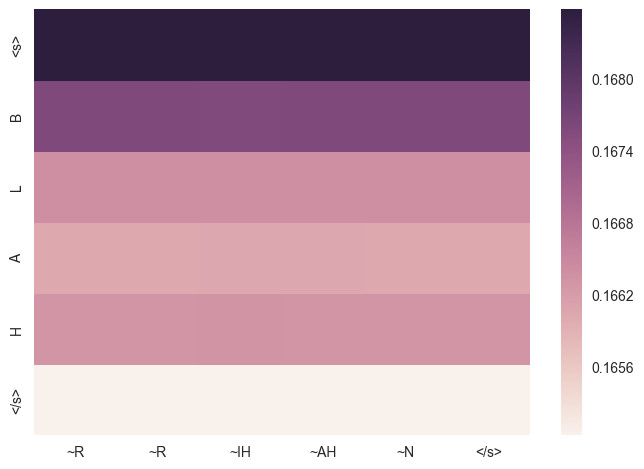

= R R IH AH N  
> quit


In [31]:
interactive_session(model, vocab, i2w, show_attention=True)

Notice how the attention weights show how important different parts of the input are for generating different tokens in the output. For tasks like machine translation, where the order of one-to-one words often changes due to grammatical differences between languages, this becomes very interesting as we see the attention window move further away from the diagonal that is mostly displayed in grapheme-to-phoneme translations.

## What's next

With the above model, you have the basics for training a powerful sequence-to-sequence model with attention in a number of distinct domains. The only major changes required are preparing a dataset with pairs input and output sequences and in general the rest of the building blocks will remain the same. Good luck, and have fun!